In [1]:
import sys
sys.path.append('..')

In [2]:
from data import dataset, generate_data
from models import RSSM, MultiRSSM, VCD
import json
from jax import random
from jax import numpy as jnp
from matplotlib import pyplot as plt
from experiments import evaluation

This following script loads trained models and evaluate their rollout accuracy. 

Each test episode is 200 frames long. The models get observations for the first 100 frames and perform prediction purely in the latent space in the final 100 frames.

Errors are measured as L2 distance in the ground-truth states.

In [3]:
data_conf = json.load(open('../data/mixed_state_data_conf.json'))
test_data_config = data_conf['test_data_conf']
mixing_matrix = random.normal(random.PRNGKey(0), (8, 12))
mixing_function = lambda x: x @ mixing_matrix

test_data = dataset.DataLoader(
    generate_data.get_states,
    test_data_config,
    1000,
    data_conf["test_data_seed"],
    mixing_function,
)

In [4]:
# change the below to the logging directories and the checkpoint ids for the models.
rssm_path = '../runs/Jun_17__13_59_50RSSM'
rssm_chkpt_id = 200
multi_path = '../runs/Jun_17__13_56_52MultiRSSM'
multi_chkpt_id = 200
vcd_path = '../runs/Jun_17__18_00_55VCD'
vcd_chkpt_id = 200

rssm_error = evaluation.state_rollout_error(test_data, RSSM.RSSM, rssm_path, rssm_chkpt_id, 100, mixing_matrix)
multi_error = evaluation.state_rollout_error(test_data, MultiRSSM.MultiRSSM, multi_path, multi_chkpt_id, 100, mixing_matrix)
vcd_error = evaluation.state_rollout_error(test_data, VCD.VCD, vcd_path, vcd_chkpt_id, 100, mixing_matrix)

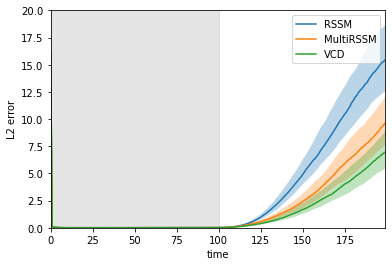

In [6]:
plt.plot(jnp.median(rssm_error, axis=1), label='RSSM')
plt.fill_between(jnp.arange(200), jnp.quantile(rssm_error, 0.75, axis=1), jnp.quantile(rssm_error, 0.25, axis=1), alpha=0.3)
plt.plot(jnp.median(multi_error, axis=1), label='MultiRSSM')
plt.fill_between(jnp.arange(200), jnp.quantile(multi_error, 0.75, axis=1), jnp.quantile(multi_error, 0.25, axis=1), alpha=0.3)
plt.plot(jnp.median(vcd_error, axis=1), label='VCD')
plt.fill_between(jnp.arange(200), jnp.quantile(vcd_error, 0.75, axis=1), jnp.quantile(vcd_error, 0.25, axis=1), alpha=0.3)
plt.fill_betweenx([0,30], [0,0], [100,100], color='k', alpha=0.1)
plt.ylim([0, 20])
plt.xlim([0,199])
plt.xlabel('time')
plt.ylabel('L2 error')
plt.legend()